# Conversion Rate Challenge

Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc

from sklearn.ensemble.partial_dependence import plot_partial_dependence

from pydotplus import graph_from_dot_data

from io import StringIO
from IPython.display import Image

from pylab import rcParams

%matplotlib inline
rcParams['figure.figsize'] = 8, 4
sns.set_style('whitegrid')

Read Data

In [2]:
data = pd.read_csv('./conversion_data.csv')

In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [4]:
data.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,316200,316200.000000,316200.000000,316200,316200.000000,316200.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,178092,NaN,NaN,155040,NaN,NaN
mean,NaN,30.569858,0.685465,NaN,4.872966,0.032258
std,NaN,8.271802,0.464331,NaN,3.341104,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [5]:
data['country'] = data['country'].astype('category')
data['source'] = data['source'].astype('category')
data['converted'] = data['converted'].astype('category')
data['new_user'] = data['new_user'].astype('category')

In [6]:
data.dtypes

country                category
age                       int64
new_user               category
source                 category
total_pages_visited       int64
converted              category
dtype: object

In [7]:
data['country'].value_counts()

US         178092
China       76602
UK          48450
Germany     13056
Name: country, dtype: int64

In [8]:
data['source'].value_counts()

Seo       155040
Ads        88740
Direct     72420
Name: source, dtype: int64

In [9]:
data['converted'].value_counts()

0    306000
1     10200
Name: converted, dtype: int64

In [10]:
data['new_user'].value_counts()

1    216744
0     99456
Name: new_user, dtype: int64

In [11]:
pd.crosstab(data['country'], data['converted'])

converted,0,1
country,,
China,76500,102
Germany,12240,816
UK,45900,2550
US,171360,6732


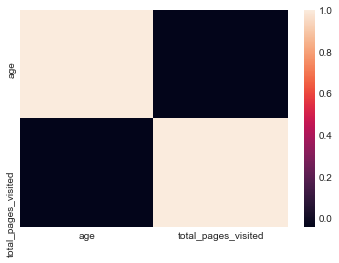

In [12]:
sns.heatmap(data.corr());

non-categorical data are not correlated.

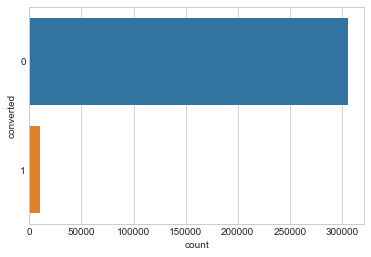

In [13]:
sns.countplot(y="converted", data=data);

Classes are imbalanced.

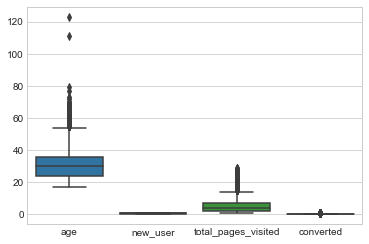

In [14]:
sns.boxplot(data=data)

There are outliers in the age column

In [15]:
data[data['age']>79]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [16]:
data = data[data['age'] < 80]

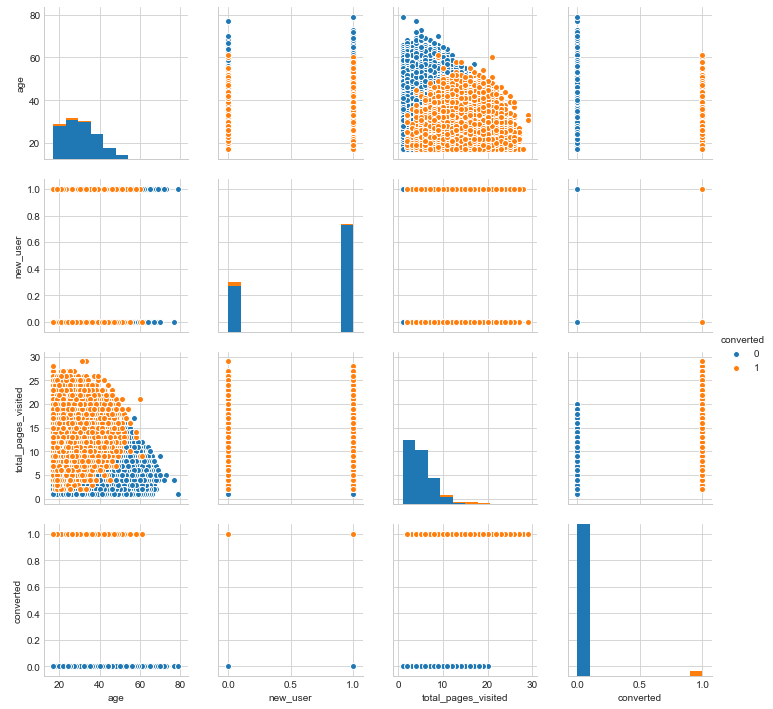

In [17]:
sns.pairplot(data, hue='converted');

In [18]:
country_conversion = data[['country', 'converted']].copy()
country_conversion.loc[:,'converted'] = country_conversion.loc[:,'converted'].astype('int');

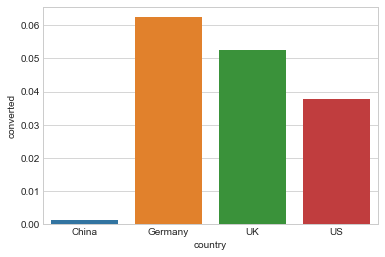

In [19]:
g = country_conversion.groupby('country').mean()
# g.plot(x=g.index, y='converted', kind='bar');
sns.barplot(x=g.index, y='converted', data=g);

Conversion rate is very low in China

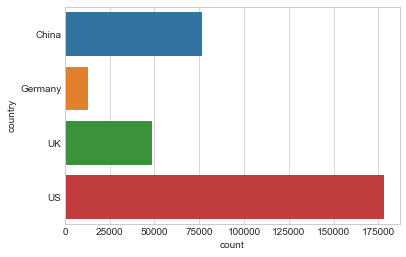

In [20]:
sns.countplot(y="country", data=data);

US has the highest number of visitors

In [21]:
pages_visit_conversion = data[['total_pages_visited', 'converted']].copy()
pages_visit_conversion.loc[:,'converted'] = pages_visit_conversion.loc[:,'converted'].astype('int');
g = pages_visit_conversion.groupby('total_pages_visited').mean()

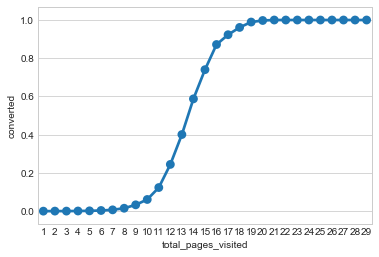

In [22]:
sns.pointplot(x=g.index, y='converted', data=g);

More pages visited, higher conversion rate

In [23]:
X = data.loc[:,['country', 'age', 'new_user', 'source', 'total_pages_visited']].copy()
y = data.loc[:,'converted'].copy()

In [24]:
X.head()

,country,age,new_user,source,total_pages_visited
0,UK,25,1,Ads,1
1,US,23,1,Seo,5
2,US,28,1,Seo,4
3,China,39,1,Seo,5
4,US,30,1,Seo,6


In [25]:
X.dtypes

country                category
age                       int64
new_user               category
source                 category
total_pages_visited       int64
dtype: object

In [26]:
le = LabelEncoder()
le.fit(X['country'])
X['country'] = le.transform(X['country'])
X['country'] = X['country'].astype('category')

le.fit(X['source'])
X['source'] = le.transform(X['source'])
X['source'] = X['source'].astype('category')

In [27]:
X.head()

,country,age,new_user,source,total_pages_visited
0,2,25,1,0,1
1,3,23,1,2,5
2,3,28,1,2,4
3,0,39,1,2,5
4,3,30,1,2,6


In [28]:
X.dtypes

country                category
age                       int64
new_user               category
source                 category
total_pages_visited       int64
dtype: object

0.9606895379793441
0.9621930883790466


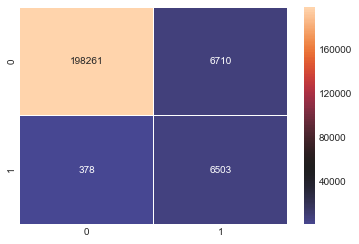

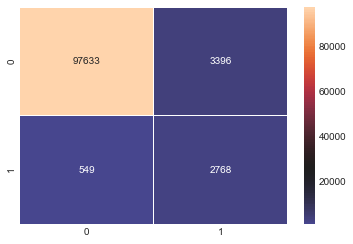

In [29]:
clf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1
                            , class_weight={0:10198, 1:306000}
                            )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf.fit(X_train,y_train)

print clf.oob_score_

y_pred = clf.predict(X_train)
cfm = confusion_matrix(y_train, y_pred)
plt.figure()
sns.heatmap(cfm, annot=True, fmt="d", linewidths=.5, center=cfm.mean());

print clf.score(X_test, y_test)

y_pred = clf.predict(X_test)
cfm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cfm, annot=True, fmt="d", linewidths=.5, center=cfm.mean());
# clf.fit(X,y)

In [30]:
y_score = clf.decision_path(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
    
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

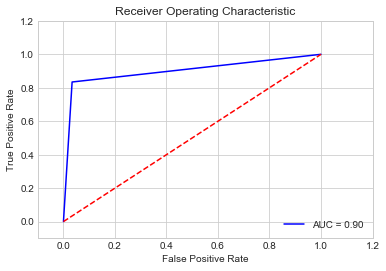

In [31]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

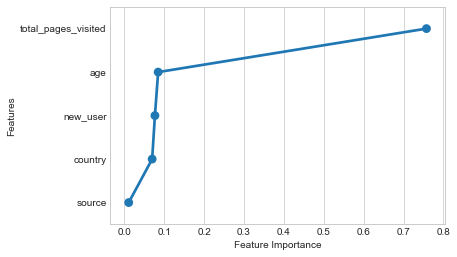

In [32]:
feature_imp = pd.DataFrame({'Feature Importance' : clf.feature_importances_, 'Features' : X.columns})
feature_imp.sort_values(by='Feature Importance', inplace=True, ascending=False)
impplot = sns.pointplot(x='Feature Importance', y = 'Features', data=feature_imp)

In [33]:
for tree_in_forest in clf.estimators_:
    export_graphviz(tree_in_forest,
                    feature_names=X.columns,
                    filled=True,
                    rounded=True,
                    rotate = True,
                    out_file = 'tree.dot')
os.system('dot -Tpng tree.dot -o tree.png');
os.system('dot -Tps tree.dot -o tree.ps');
os.system('dot -Tdf tree.dot -o tree.pdf');

Explained Variance Ratio =  [0.83365653 0.1357525 ]


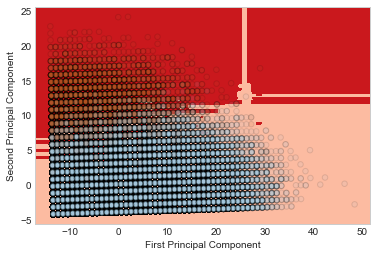

In [34]:
pca = PCA(n_components=2)
pca.fit(X)
X_new = pca.transform(X)
print 'Explained Variance Ratio = ',pca.explained_variance_ratio_
clf.fit(X_new,y)
ax = plt.gca()
cmap = 'rainbow'  
# Plot the training points
ax.scatter(X_new[:,0], X_new[:,1], c=y, s=30, cmap=plt.cm.Paired,
           edgecolors='k', zorder=2, alpha=0.1)
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
# ax.axis('tight')
# ax.axis('off')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                     np.linspace(*ylim, num=200))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
# Create a color plot with the results
n_classes = len(np.unique(y))
contours = ax.contourf(xx, yy, Z, #alpha=0.3,
                       levels=np.arange(n_classes + 1) - 0.5,
                       cmap=plt.cm.Reds,
                       zorder=1)

In [35]:
X.drop('total_pages_visited', axis=1, inplace=True)

In [36]:
X.head()

,country,age,new_user,source
0,2,25,1,0
1,3,23,1,2
2,3,28,1,2
3,0,39,1,2
4,3,30,1,2


In [37]:
X.dtypes

country     category
age            int64
new_user    category
source      category
dtype: object

0.7342201159299888
0.731345715216683


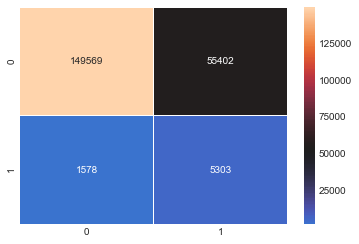

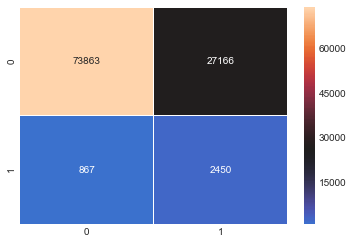

In [38]:
clf = RandomForestClassifier(n_estimators=100, 
                             oob_score=True, n_jobs=-1, 
                             max_features=3, class_weight={0:10198, 1:306000})#class_weight={0:.3, 1:.7})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf.fit(X_train,y_train)

print clf.oob_score_

y_pred = clf.predict(X_train)
cfm = confusion_matrix(y_train, y_pred)
plt.figure()
sns.heatmap(cfm, annot=True, fmt="d", linewidths=.5, center=cfm.mean());

print clf.score(X_test, y_test)

y_pred = clf.predict(X_test)
cfm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cfm, annot=True, fmt="d", linewidths=.5, center=cfm.mean());

In [39]:
X.dtypes

country     category
age            int64
new_user    category
source      category
dtype: object

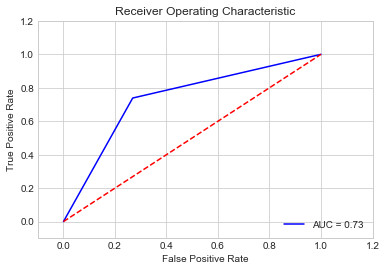

In [40]:
y_score = clf.decision_path(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
    
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

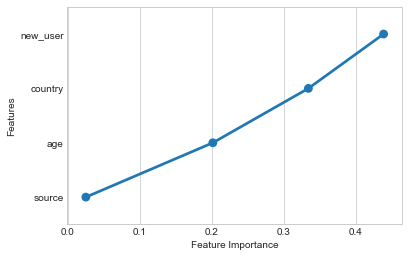

In [41]:
feature_imp = pd.DataFrame({'Feature Importance' : clf.feature_importances_, 'Features' : X.columns})
feature_imp.sort_values(by='Feature Importance', inplace=True, ascending=False)
impplot = sns.pointplot(x='Feature Importance', y = 'Features', data=feature_imp)

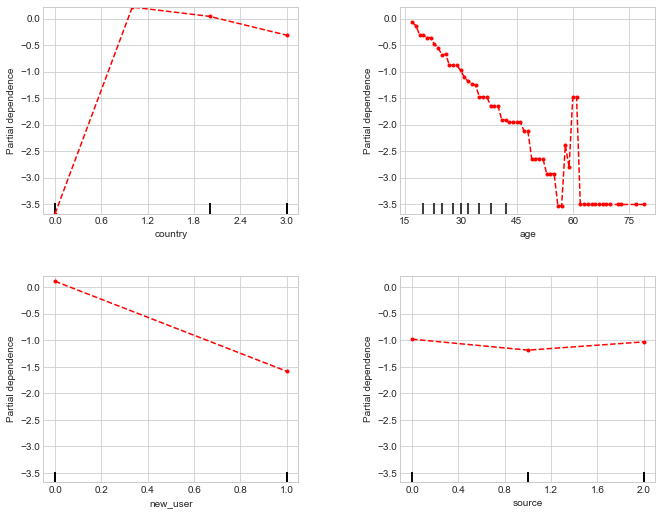

In [42]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                max_depth=1, random_state=0).fit(X, y)
features = X.columns.values
names = X.columns.values
fig, axs = plot_partial_dependence(clf, X, features, feature_names=names
                                   , n_cols=2, figsize=(10,12),
                                   line_kw={'linestyle':'--', 'marker':'o', 
                                            'color':'red', 'markersize':3})

In [43]:
X['country'] = X['country'].astype('category')

In [44]:
X.dtypes

country     category
age            int64
new_user    category
source      category
dtype: object

In [45]:
X.head()

,country,age,new_user,source
0,2,25,1,0
1,3,23,1,2
2,3,28,1,2
3,0,39,1,2
4,3,30,1,2


In [46]:
clf = DecisionTreeClassifier(max_depth=3,
                             class_weight={0:101985/5., 1:306000})
clf.fit(X,y)
print clf.score(X, y)

0.8790536309527575


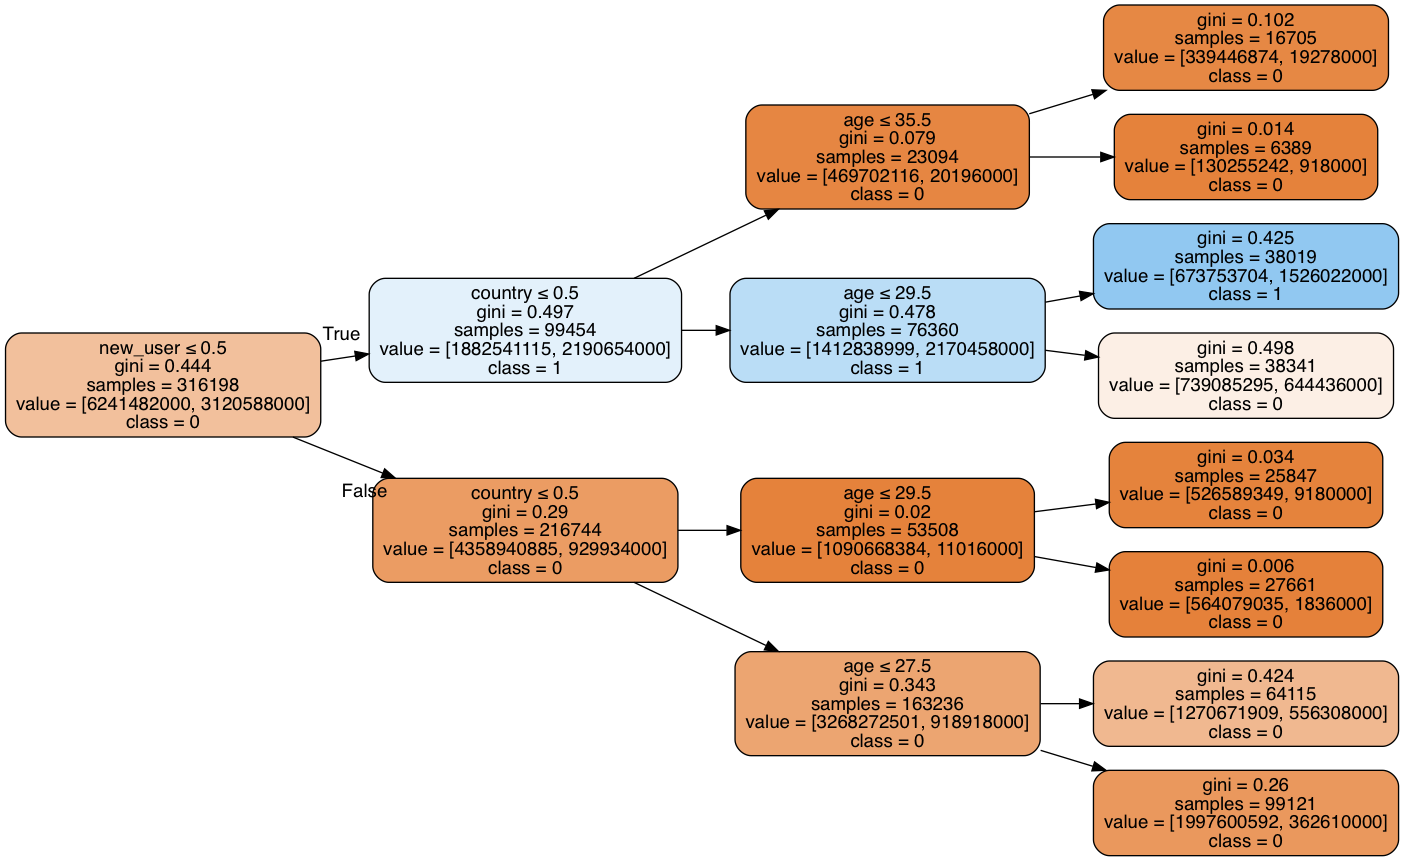

In [47]:
outfile = 'DecisionTreeClassifier.dot'
export_graphviz(clf, feature_names=X.columns, 
                class_names=['0', '1'], filled=True, 
                out_file=outfile,
                special_characters=True)
os.system('dot -Tpdf DecisionTreeClassifier.dot -o DecisionTreeClassifier.pdf');

tree = export_graphviz(clf, feature_names=X.columns, 
                       class_names=['0', '1'], filled=True, rounded=True,
                       out_file=None, special_characters=True, rotate=True)

graph = graph_from_dot_data(tree)
Image(graph.create_png())